**Upload CSV File to Colab**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving news_summary.csv to news_summary.csv


**Load CSV File into Pandas**

In [ ]:
import pandas as pd

csv_filename = 'news_summary.csv'

df = pd.read_csv(csv_filename, encoding='latin1')
df.dropna(inplace=True)
df.head()


,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


**Preprocessing**

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^A-Za-z0-9. ]+', '', text)
    return text.lower()

# Apply cleaning
df['text'] = df['text'].apply(clean_text)
df['ctext'] = df['ctext'].apply(clean_text)

# Show sample cleaned data
df[['text', 'ctext']].head(5)


,text,ctext
0,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika arora slammed an instagram user who tr...,from her special numbers to tvappearances boll...
2,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,lashkaretaibas kashmir commander abu dujana wh...,lashkaretaibas kashmir commander abu dujana wa...
4,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


**Summarization Model (Extractive using TF-IDF + TextRank)**

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# Function to split article into sentences
def sentence_tokenize(text):
    return text.split('. ')  # simple split on period + space

# Summarization function
def extractive_summary(text, top_n=3):
    sentences = sentence_tokenize(text)
    if len(sentences) <= top_n:
        return text  # If text is short, return as is

    # Compute TF-IDF matrix for sentences
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Compute similarity matrix
    sim_matrix = cosine_similarity(tfidf_matrix)

    # Build graph and rank sentences using PageRank
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)

    # Rank sentences and pick top_n
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    summary_sentences = [s for _, s in ranked_sentences[:top_n]]

    # Join summary sentences
    summary = '. '.join(summary_sentences)
    return summary

# Example: summarize first article in 'text' column and compare with 'ctext'
example_article = df['text'].iloc[0]
example_summary = df['ctext'].iloc[0]

print("Original Article:\n", example_article)
print("\nActual Summary:\n", example_summary)
print("\nGenerated Summary:\n", extractive_summary(example_article, top_n=2))


Original Article:
 the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august 7. the administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.

Actual Summary:
 the daman and diu administration on wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.the union territorys administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate rakshabandhan at workplace.it has been decided to celebrate the festival of rakshabandhan on august 7. in this connection all offices departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady 

**Parameter**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx

# Parameters to tweak
top_n = 3
max_features = 5000
stop_words = 'english'
ngram_range = (1,2)
pagerank_alpha = 0.85

# Use parameters in your summarization function
def extractive_summary(text, top_n=top_n):
    sentences = text.split('. ')
    if len(sentences) <= top_n:
        return text

    vectorizer = TfidfVectorizer(max_features=max_features, stop_words=stop_words, ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(sentences)
    sim_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()

    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph, alpha=pagerank_alpha)

    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    summary_sentences = [s for _, s in ranked_sentences[:top_n]]

    return '. '.join(summary_sentences)

# Test it on your first article
example_text = df['text'].iloc[0]
summary = extractive_summary(example_text, top_n)
print("Summary:\n", summary)


Summary:
 the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august 7. the administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.


**True Positive, False Positive, False Negative Calculation**

In [ ]:
def compute_tp_fp_fn(reference, generated):
    ref_words = set(reference.lower().split())
    gen_words = set(generated.lower().split())
    TP = len(ref_words.intersection(gen_words))
    FP = len(gen_words.difference(ref_words))
    FN = len(ref_words.difference(gen_words))
    return TP, FP, FN

# Use your example article and summary
reference_summary = df['ctext'].iloc[0]   # Actual summary
generated_summary = extractive_summary(df['text'].iloc[0], top_n=top_n)  # Generated summary from Step 1

TP, FP, FN = compute_tp_fp_fn(reference_summary, generated_summary)
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


True Positives (TP): 37
False Positives (FP): 9
False Negatives (FN): 175


**Heatmap (Sentence Similarity Matrix)**

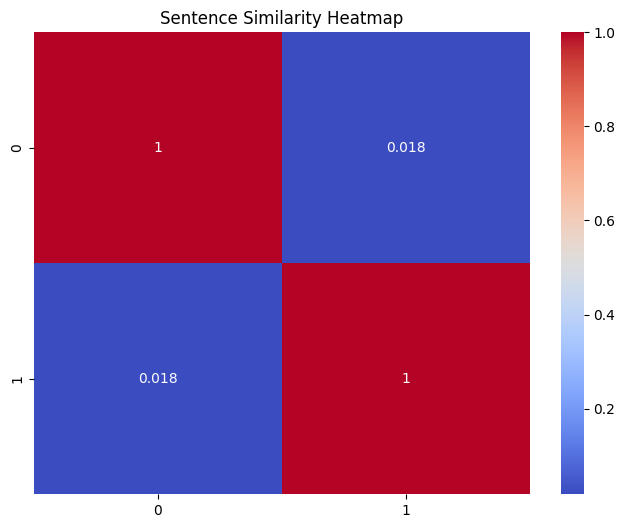

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Prepare sentences from the example article
sentences = df['text'].iloc[0].split('. ')
sentences = [s.strip() for s in sentences if s]

# Compute TF-IDF matrix for sentences
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(sentences)

# Compute cosine similarity matrix
sim_matrix = cosine_similarity(tfidf_matrix)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(sim_matrix, annot=True, cmap='coolwarm')
plt.title('Sentence Similarity Heatmap')
plt.show()


**Feature Matrix (TF-IDF Matrix)**

In [ ]:
# Show shape of the TF-IDF matrix
print("TF-IDF Feature Matrix shape:", tfidf_matrix.shape)

# Convert sparse matrix to dense format (for small examples only)
dense_tfidf = tfidf_matrix.todense()

# Show the matrix (you can print part of it)
print("TF-IDF Feature Matrix (dense format):")
print(dense_tfidf)

# Optional: print feature names (vocabulary)
print("Feature names:")
print(vectorizer.get_feature_names_out())


TF-IDF Feature Matrix shape: (2, 57)
TF-IDF Feature Matrix (dense format):
[[0.         0.         0.12882067 0.         0.18105296 0.18105296
  0.         0.         0.18105296 0.18105296 0.18105296 0.18105296
  0.18105296 0.18105296 0.         0.         0.18105296 0.18105296
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.18105296 0.18105296
  0.         0.18105296 0.18105296 0.18105296 0.18105296 0.18105296
  0.18105296 0.18105296 0.18105296 0.         0.         0.18105296
  0.18105296 0.         0.         0.         0.         0.18105296
  0.18105296 0.18105296 0.18105296 0.18105296 0.18105296 0.
  0.         0.18105296 0.18105296]
 [0.19423429 0.19423429 0.1381993  0.19423429 0.         0.
  0.19423429 0.19423429 0.         0.         0.         0.
  0.         0.         0.19423429 0.19423429 0.         0.
  0.19423429 0.19423429 0.19423429 0.19423429 0.19423429 0.19423429
  0.19423429 0.19423429 0.19423429 0.19423429

**Hyperparameter Tuning**

In [ ]:
# Try different top_n values and observe TP, FP, FN
for top_n_test in [1, 2, 3, 4, 5]:
    gen_summary = extractive_summary(df['text'].iloc[0], top_n=top_n_test)
    TP, FP, FN = compute_tp_fp_fn(df['ctext'].iloc[0], gen_summary)
    print(f"top_n = {top_n_test} --> TP: {TP}, FP: {FP}, FN: {FN}")


top_n = 1 --> TP: 18, FP: 6, FN: 194
top_n = 2 --> TP: 37, FP: 9, FN: 175
top_n = 3 --> TP: 37, FP: 9, FN: 175
top_n = 4 --> TP: 37, FP: 9, FN: 175
top_n = 5 --> TP: 37, FP: 9, FN: 175
